# Лабараторная работа №3
### Выполнил: Росляков Владислав Александрович
### Группа: ББМО-01-23

### Шаг 1. Импортирую необходимые библиотеки.

In [31]:
!pip install tf-keras-vis

In [32]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import tensorflow as tf
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16 as Model

### Шаг 2. Загружаю и предобработываю исходные изображения.

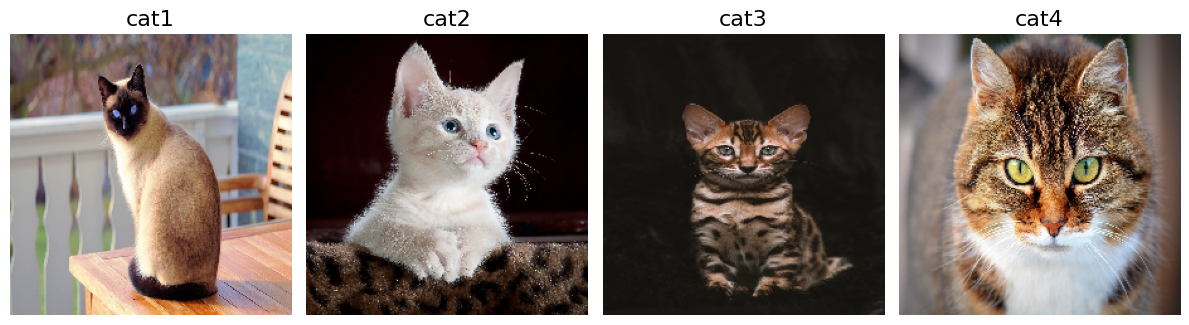

In [40]:
# Заголовки наших изображений
image_titles = ['cat1', 'cat2', 'cat3', 'cat4']

# Загружаем изображения и конвертируем их в массив Numpy
img1 = load_img('cat1.jpg', target_size=(224, 224))
img2 = load_img('cat2.jpg', target_size=(224, 224))
img3 = load_img('cat3.jpg', target_size=(224, 224))
img4 = load_img('cat4.jpg', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4)])

# Подготавливаем входы для VGG16
X = preprocess_input(images)

# Выводим
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [34]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

### Шаг 3. В данном шаге мы создаем экземпляр Score или определяем score function, которая возвращает целевые баллы.

In [35]:
from tf_keras_vis.utils.scores import CategoricalScore

score = CategoricalScore([285, 277, 330, 675])
# Где: 277 - лиса, 285 - кошка, 330 - кролик, 675 - мыш

# Вместо использования объекта CategoricalScore
# определим функцию с нуля следующим образом:
def score_function(output):
    # Переменная `output` ссылается на выходы модели,
    # таким образом, что размерность `output` равна `(3, 1000)` где, (номер примера, номер класса)
    return (output[0][285], output[1][277], output[2][330], output[3][675])

### Шаг 4. Saliency генерирует карту значимости, на которой отображаются области входного изображения, которые имеют наибольшее влияние на выходное значение.

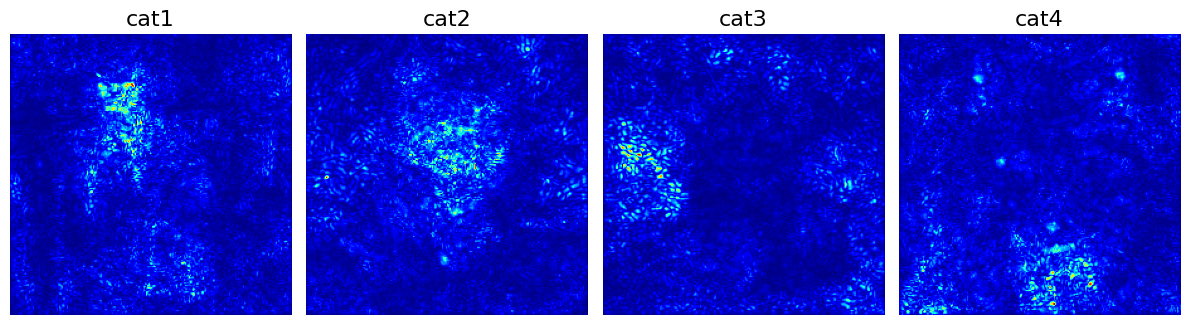

CPU times: user 4.45 s, sys: 1.21 s, total: 5.66 s
Wall time: 7.69 s


In [36]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

# Создаем объект внимания
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Генерируем карту внимания
saliency_map = saliency(score, X)

# Выводим
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

### Шаг 5. SmoothGrad.Карта значимости Vanilla слишком шумная, поэтому следует удалить шум на карте значимости с помощью SmoothGrad.

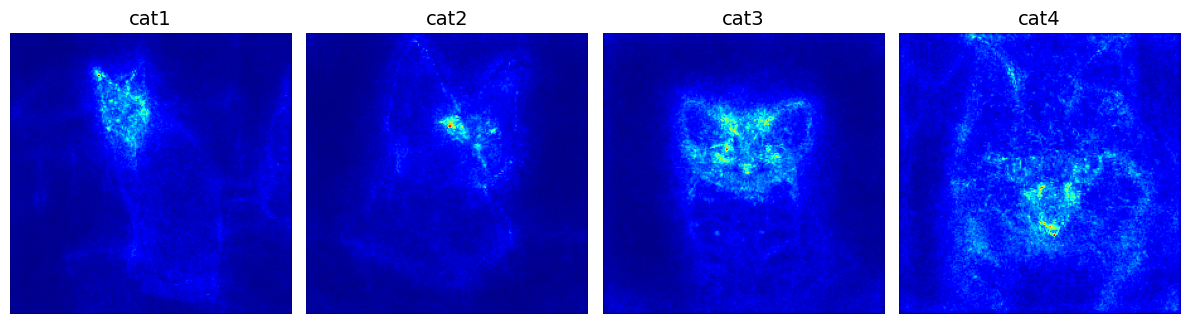

CPU times: user 2.25 s, sys: 252 ms, total: 2.5 s
Wall time: 3.52 s


In [37]:
%%time

# Генерируем карту внимания со сглаживанием, которое уменьшает шум за счет добавления шума
saliency_map = saliency(score,
                        X,
                        smooth_samples=20, # Количество итераций расчета градиентов
                        smooth_noise=0.20) # уровень распространения шума

# Выводим
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('smoothgrad.png')
plt.show()

### Шаг 6. Визуализация тепловой карты - GradCAM. Вместо использования градиентов выходных данных модели он использует выходные данные предпоследнего слоя (то есть сверточного слоя непосредственно перед плотными слоями).
### Функция визуализации GradCam получает 4 аргумента: model это изученная модель, X это пустой массив предварительно обработанных входных изображений, image_titles это соответствующие имена классов изображений в X, images это пустой массив исходных входных изображений.

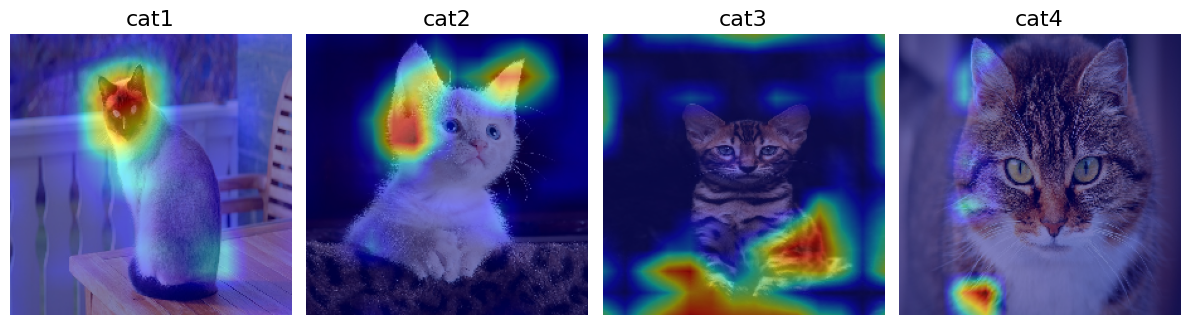

CPU times: user 1.43 s, sys: 888 ms, total: 2.32 s
Wall time: 2.21 s


In [38]:
%%time

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Создаём объект визуализации Gradcam
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Генерируем тепловую карту с помощью GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

# Выводим
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :4] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

### Шаг 8. GradCam++ — улучшенная версия GradCam. Этот метод может обеспечить лучшее визуальное объяснение прогнозов модели CNN.

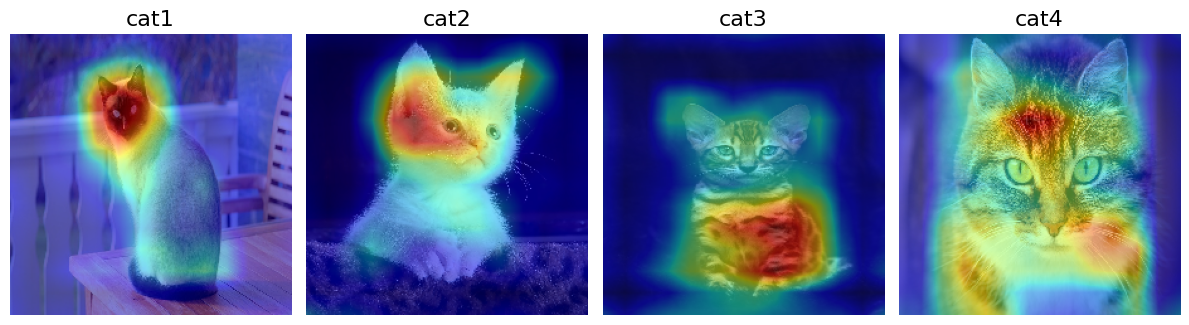

CPU times: user 1.83 s, sys: 840 ms, total: 2.67 s
Wall time: 2.59 s


In [39]:
%%time

from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

# Создаем объект GradCAM++
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)
# Генерируем тепловую карту с помощью GradCAM++
cam = gradcam(score,
              X,
              penultimate_layer=-1)
# Визуализируем
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :4] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('gradcam_plus_plus.png')
plt.show()

## Вывод: В ходе работы мы научились покрывать изображения тепловыми пятнами